In [1]:
import pickle
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

%matplotlib inline

### Helper Functions

The first two are for loading and storing dictionaries to/from a pickle file

In [2]:
def store_dict_pickle(file_name, dictionary):
    """
        Saves a dictionary to a pickle file

        :param file_name: the name of the file the data will be stored in
        :type file_name: str

        :param dictionary: the dictionary to be stored in the file
        :type dictionary: dict
    """

    with open('data/' + file_name + '.pkl', 'wb') as f:
        pickle.dump(dictionary, f, pickle.HIGHEST_PROTOCOL)


def load_dict_pickle(file_name):
    """
    Retrieves a dictionary form the specified file

    :param file_name: the name of the file to load
    :type file_name: str

    :return: the dictionary retrieved from the file
    :rtype dict
    """

    with open('data/' + file_name + '.pkl', 'rb') as f:
        dictionary =  pickle.load(f)
    return dictionary

# Loading Artist-Country Data

In [3]:
#intializing dictionary variables
dict_05 = load_dict_pickle("2005_country_artist")
dict_06 = load_dict_pickle("2006_country_artist")
dict_07 = load_dict_pickle("2007_country_artist")
dict_08 = load_dict_pickle("2008_country_artist")
dict_09 = load_dict_pickle("2009_country_artist")
dict_10 = load_dict_pickle("2010_country_artist")
dict_13 = load_dict_pickle("2013_country_artist")

# Initializing Graphs From Dictionaries

In [4]:
import copy

def top_artists(year_dict, top_number):
    # create graph to represent trends for given year
    G = nx.Graph()
    
    # loop through each artist in the dictionary
    for country in year_dict:
        # create country node & add it
        G.add_node(country)
        G.node[country]['country'] = True
        
        # get top 5 artists for current country
        artists = copy.copy(year_dict[country])
        num_artist = len(artists)
        for i in range(top_number):
            # make sure the country has enough top artists
            if( num_artist < top_number):
                # remove country's node and skip it
                G.remove_node(country)
                break;
            
            # find ith top artist
            top = max(artists.keys(), key=(lambda k: artists[k]))
            
            #create node for ith top artist and make a conenction b/n it and the country
            G.add_node(top)
            G.node[top]['artist'] = True
            G.add_edge(country, top, weight=year_dict[country][top])
            
            artists.pop(top)

    return G

In [5]:
# pos = nx.spring_layout(G)
# nx.draw(G, pos=pos);
# plt.axis('off')
# plt.show()

G_05 = top_artists(dict_05, 5)
G_06 = top_artists(dict_06, 5)
G_07 = top_artists(dict_07, 5)
G_08 = top_artists(dict_08, 5)
G_09 = top_artists(dict_09, 5)

# Takes two lists and calculates the JS Index associated with them.
# Returns JS Index as a float
def Jaccard(neighborhood1, neighborhood2):
    """
        J(A,B) = |A n B| / |A U B| 
        A n B = elements in A AND B 
        A U B = elments in A OR B
    """
    #want to iterate through longer list;
    if len(neighborhood1) >= len(neighborhood2):
        list1 = neighborhood1
        list2 = neighborhood2
    else:
        list1 = neighborhood2
        list2 = neighborhood1
    
    #AND --> A n B
    intersection = 0
    #OR --> A U B
    #combined the lists & then get the set to only have unique occurrences. Then get the length
    union = len(set(list1 + list2))
    
    #find the number of concordant and discordant nodes
    for node in list1:
        #if it's concordant
        if node in list2:
            intersection += 1

    #calculate index
    return intersection / union

In [18]:
index = Jaccard(G_08.neighbors('United States'), G_09.neighbors('United States'))

# put the years in a dictionary
graph_years = {5: G_05, 6: G_06, 7: G_07, 8: G_08, 9: G_09}
years = [G_05, G_06, G_07, G_08, G_09]

def years_similarity(years):
    # getting Jaccard similarity for each country from years 2005-2006. Where the similarity is calculated for consecutive years
    
    # make dicionary to hold all similariteis
    # dict['country'] = [05-06, 06-07, 07-08, 08-09] if value is not available, then it equals -1
    results = dict()
    
    # get all countries from the graph
    for graph in years:
        x=1
        for country in nx.get_node_attributes(graph, 'country').keys():
            if not country in results:
                results[country] = list()
                
    # get Jaccard Similarities
    for i in range(len(years) - 1):
        # get the jaccard similarity for the current year and next year countries
        for country in results:
            current_year = years[i] 
            next_year = years[i+1]
            if country in current_year and country in next_year:
                index = Jaccard(current_year.neighbors(country), next_year.neighbors(country))
                results[country].append(index)
            else:
                results[country].append(-1)
                
    return results

x = years_similarity(years)

['Incubus', 'Joy Division', 'Depeche Mode', 'Indochine', 'Muse']


# Put Jaccard Similarities into CSV File

In [55]:
import csv

def write_Jaccard_to_CSV(similarities):
    file = open('data/jaccard_indexes.csv', 'w', newline='')
    writer = csv.writer(file)

    # make header row
    row = []
    row.append('Country')
    row.append('2005-2006')
    row.append('2006-2007')
    row.append('2007-2008')
    row.append('2008-2009')

    writer.writerow(row)

    # write all the results from getting the Jaccard Similarities for
    # all the countries
    for country in similarities:
        row = []
        row.append(country)
        for item in similarities[country]:
            row.append(item)
        writer.writerow(row)
        
    file.close()
    
write_Jaccard_to_CSV(x)

# Getting Results

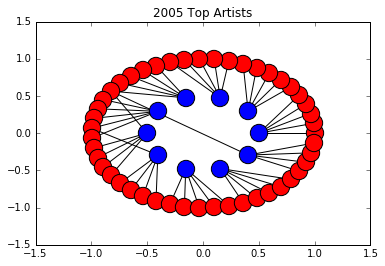

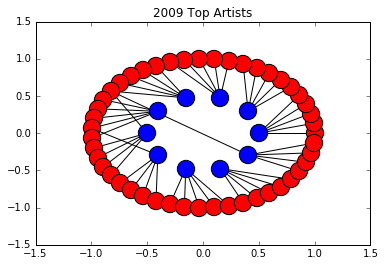

In [151]:
# graphing networks for 2005 & 2009
# nx.get_node_attributes(G_05, )

def top_artists_graph(G):
    # top 10 countries that use Last.fm
    top_countries = ['United States', 'United Kingdom', 'Poland', 'Germany', 'Norway', 'Finland', 'Canada', 
                 'Turkey', 'Italy', 'Sweden']
    top_graph = G_05.subgraph(top_countries)
    
    artist_list = list()
    edge_list = []
    for country in top_countries:
        # get neighbor and add it to the graph with appropriate edges
        neighbors = G_05.neighbors(country)
        for artist in neighbors:
            # if it's not in the graph add it
            if not artist in top_graph:
                top_graph.add_node(artist)
                artist_list.append(artist)
            # add edge for current country and artist
            top_graph.add_edge(country, artist)
            edge_list.append((country, artist))
    return top_graph, top_countries, artist_list, edge_list

plt.figure(1)
plt.subplot()
top_05, countries, artists, edges = top_artists_graph(G_05)
pos = nx.random_layout(top_05)

shells = [countries, artists]
pos = nx.shell_layout(top_05, shells)

nx.draw_networkx_nodes(top_05, pos, nodelist=countries, node_color="b")
nx.draw_networkx_nodes(top_05, pos, nodelist=artists, node_color="r")

nx.draw_networkx_edges(top_05, pos)
# nx.draw_networkx_labels(top_05, pos)

plt.title('2005 Top Artists')
plt.show()

# Plot 2009
plt.figure(2)
plt.subplot()
top_09, countries, artists, edges = top_artists_graph(G_09)
pos = nx.random_layout(top_09)

shells = [countries, artists]
pos = nx.shell_layout(top_09, shells)

nx.draw_networkx_nodes(top_09, pos, nodelist=countries, node_color="b")
nx.draw_networkx_nodes(top_09, pos, nodelist=artists, node_color="r")

nx.draw_networkx_edges(top_09, pos)

plt.title('2009 Top Artists')
plt.show()

# Displaying Top Artists for Each Country

In [43]:
# United States
print('United States Top Artists 2005-2009')
print('2005: %r \n' % G_05.neighbors('United States'))
print('2006: %r \n' % G_06.neighbors('United States'))
print('2007: %r \n' % G_07.neighbors('United States'))
print('2008: %r \n' % G_08.neighbors('United States'))
print('2009: %r \n' % G_09.neighbors('United States'))

United States Top Artists 2005-2009
2005: ['Bright Eyes', 'Death Cab For Cutie', 'Elliott Smith', 'Broken Social Scene', 'Everclear'] 

2006: ['The Beatles', 'Radiohead', 'Death Cab For Cutie', 'Elliott Smith', 'Metric'] 

2007: ['The Beatles', 'Modest Mouse', 'Humanwine', 'Radiohead', 'Death Cab For Cutie'] 

2008: ['Nine Inch Nails', 'The Beatles', 'Radiohead', 'Elliott Smith', 'Girl Talk'] 

2009: ['The Beatles', 'Nine Inch Nails', 'Alkaline Trio', 'Radiohead', 'Fear Before The March Of Flames'] 



In [44]:
print('United States Top Artists 2005-2009')
print('2005: %r \n' % G_05.neighbors('United Kingdom'))
print('2006: %r \n' % G_06.neighbors('United Kingdom'))
print('2007: %r \n' % G_07.neighbors('United Kingdom'))
print('2008: %r \n' % G_08.neighbors('United Kingdom'))
print('2009: %r \n' % G_09.neighbors('United Kingdom'))

United States Top Artists 2005-2009
2005: ['The Smiths', 'Idlewild', 'Radiohead', 'Suede', 'Easyworld'] 

2006: ['Snow Patrol', 'Belle And Sebastian', 'Radiohead', 'Mando Diao', 'Muse'] 

2007: ['The Beatles', 'Death Cab For Cutie', 'The Fray', 'Travis', 'Arcade Fire'] 

2008: ['Travis', 'Radiohead', 'Muse', 'Coldplay', 'Bloc Party'] 

2009: ['The Veronicas', 'Radiohead', 'Muse', 'Coldplay', 'Travis'] 



In [45]:
print('United States Top Artists 2005-2009')
print('2005: %r \n' % G_05.neighbors('Poland'))
print('2006: %r \n' % G_06.neighbors('Poland'))
print('2007: %r \n' % G_07.neighbors('Poland'))
print('2008: %r \n' % G_08.neighbors('Poland'))
print('2009: %r \n' % G_09.neighbors('Poland'))

United States Top Artists 2005-2009
2005: ['My Dying Bride', 'Battlelore', "Leaves' Eyes", 'Draconian', 'Dir En Grey'] 

2006: ['Mucc', 'ムック', '雅-Miyavi-', 'Acidman', 'Dir En Grey'] 

2007: ['Björk', 'Nine Inch Nails', 'System Of A Down', 'Depeche Mode', 'Dir En Grey'] 

2008: ['Nine Inch Nails', 'Kult', 'Metallica', 'Coldplay', 'System Of A Down'] 

2009: ['Nine Inch Nails', 'Skinny Puppy', 'System Of A Down', 'Placebo', 'Sting'] 



In [47]:
print('Germany Top Artists 2005-2009')
print('2005: %r \n' % G_05.neighbors('Germany'))
print('2006: %r \n' % G_06.neighbors('Germany'))
print('2007: %r \n' % G_07.neighbors('Germany'))
print('2008: %r \n' % G_08.neighbors('Germany'))
print('2009: %r \n' % G_09.neighbors('Germany'))

Germany Top Artists 2005-2009
2005: ['Air', 'Massive Attack', 'Metallica', 'Tindersticks', 'System Of A Down'] 

2006: ['Led Zeppelin', 'The Kinks', 'The Strokes', 'Zao', 'Mando Diao'] 

2007: ['Modest Mouse', 'Boards Of Canada', 'Akira Yamaoka', 'Mando Diao', 'Man Or Astro-Man?'] 

2008: ['Nine Inch Nails', 'Akira Yamaoka', 'Massive Attack', 'Story One', 'Gustavo Santaolalla'] 

2009: ['U2', 'Clint Mansell', 'Depeche Mode', 'Portishead', 'Muse'] 



In [49]:
print('Norway Top Artists 2005-2009')
print('2005: %r \n' % G_05.neighbors('Norway'))
print('2006: %r \n' % G_06.neighbors('Norway'))
print('2007: %r \n' % G_07.neighbors('Norway'))
print('2008: %r \n' % G_08.neighbors('Norway'))
print('2009: %r \n' % G_09.neighbors('Norway'))

Norway Top Artists 2005-2009
2005: ['The Clash', 'Lillebjørn Nilsen', 'Bel Canto', 'Enya', 'David Gray'] 

2006: ['Johnny Cash', 'Unter Null', 'Guided By Voices', 'Bel Canto', 'Tori Amos'] 

2007: ['Bel Canto', 'Radiohead', 'Guided By Voices', 'Tori Amos', 'The National'] 

2008: ['Nine Inch Nails', 'Turbonegro', 'Loreena Mckennitt', 'Raga Rockers', 'Muse'] 

2009: ['Wolfgang Amadeus Mozart', 'Backstreet Boys', 'Underground Kingz', 'Daft Punk', 'Michael Jackson'] 



In [50]:
print('Finland Top Artists 2005-2009')
print('2005: %r \n' % G_05.neighbors('Finland'))
print('2006: %r \n' % G_06.neighbors('Finland'))
print('2007: %r \n' % G_07.neighbors('Finland'))
print('2008: %r \n' % G_08.neighbors('Finland'))
print('2009: %r \n' % G_09.neighbors('Finland'))

Finland Top Artists 2005-2009
2005: ['Paradise Lost', 'Ensiferum', 'Machinae Supremacy', 'Rush', 'System Of A Down'] 

2006: ['Tool', 'Children Of Bodom', 'Metallica', 'Type O Negative', 'The 69 Eyes'] 

2007: ['In Flames', 'Metallica', 'Red Hot Chili Peppers', 'Mokoma', 'The 69 Eyes'] 

2008: ['In Flames', 'Paradise Lost', 'Kotiteollisuus', 'Machinae Supremacy', 'The 69 Eyes'] 

2009: ['Paradise Lost', 'Kotiteollisuus', 'Metallica', '1200 Micrograms', 'The 69 Eyes'] 



In [51]:
print('Canada Top Artists 2005-2009')
print('2005: %r \n' % G_05.neighbors('Canada'))
print('2006: %r \n' % G_06.neighbors('Canada'))
print('2007: %r \n' % G_07.neighbors('Canada'))
print('2008: %r \n' % G_08.neighbors('Canada'))
print('2009: %r \n' % G_09.neighbors('Canada'))

Canada Top Artists 2005-2009
2005: ['Rockapella', 'Dan Gibson', 'Evanescence', 'Céline Dion', 'Enya'] 

2006: ['Pink Floyd', 'Broadcast', 'Evanescence', 'Sigur Rós', 'The 69 Eyes'] 

2007: ['The Doors', 'Nine Inch Nails', 'Klaxons', 'The Protomen', 'The 69 Eyes'] 

2008: ['The Doors', 'Nine Inch Nails', 'Eminem', 'The Beatles', 'Hawkwind'] 

2009: ['Hawkwind', 'Modest Mouse', 'Nirvana', 'Foo Fighters', 'Sigur Rós'] 



In [52]:
print('Turkey Top Artists 2005-2009')
print('2005: %r \n' % G_05.neighbors('Turkey'))
print('2006: %r \n' % G_06.neighbors('Turkey'))
print('2007: %r \n' % G_07.neighbors('Turkey'))
print('2008: %r \n' % G_08.neighbors('Turkey'))
print('2009: %r \n' % G_09.neighbors('Turkey'))

Turkey Top Artists 2005-2009
2005: ['Boards Of Canada', 'Vitalic', 'Depeche Mode', 'Sigur Rós', 'Röyksopp'] 

2006: ['Tool', 'Tenhi', 'Frédéric Chopin', 'Pain Of Salvation', 'Death'] 

2007: ['Tool', 'Queensrÿche', 'Radiohead', 'Porcupine Tree', 'Tori Amos'] 

2008: ['Café Del Mar', 'Madonna', 'Danny Elfman', 'Portishead', 'Ulver'] 

2009: ['Eddie Vedder', 'Radiohead', 'Röyksopp', 'Hayko Cepkin', 'Leonard Cohen'] 



In [53]:
print('Italy Top Artists 2005-2009')
print('2005: %r \n' % G_05.neighbors('Italy'))
print('2006: %r \n' % G_06.neighbors('Italy'))
print('2007: %r \n' % G_07.neighbors('Italy'))
print('2008: %r \n' % G_08.neighbors('Italy'))
print('2009: %r \n' % G_09.neighbors('Italy'))

Italy Top Artists 2005-2009
2005: ['In Flames', 'Judas Priest', 'Lacuna Coil', 'Månegarm', 'Children Of Bodom'] 

2006: ['Sentenced', 'Björk', 'Blind Guardian', 'Placebo', 'The Gathering'] 

2007: ['Sentenced', 'Him', 'Metallica', 'The Gathering', 'Nightwish'] 

2008: ['Tristania', 'Elio E Le Storie Tese', 'Blind Guardian', 'The Gathering', 'Nightwish'] 

2009: ['Vasco Rossi', 'Michael Jackson', 'Misfits', 'Joy Division', 'Elio E Le Storie Tese'] 



In [54]:
print('Sweden Top Artists 2005-2009')
print('2005: %r \n' % G_05.neighbors('Sweden'))
print('2006: %r \n' % G_06.neighbors('Sweden'))
print('2007: %r \n' % G_07.neighbors('Sweden'))
print('2008: %r \n' % G_08.neighbors('Sweden'))
print('2009: %r \n' % G_09.neighbors('Sweden'))

Sweden Top Artists 2005-2009
2005: ['Deftones', 'Melvins', 'Kent', 'The Legendary Pink Dots', 'System Of A Down'] 

2006: ['Pantera', 'Melvins', 'Soilwork', 'Black Flag', 'Sabaton'] 

2007: ['Kings Of Leon', 'Disturbed', 'Soilwork', 'Black Rebel Motorcycle Club', 'Sonic Syndicate'] 

2008: ['Disturbed', 'Sonic Syndicate', 'Manu Chao', 'Black Rebel Motorcycle Club', 'The Strokes'] 

2009: ['Kamelot', 'Kings Of Leon', 'Soilwork', 'Volbeat', 'Mando Diao'] 

